this notebook aims to use MLP in sklearn to perform DNN using BOW model.   
stop-word is reserved such that the data can be later used in RNN and CNN model
four major data sets will be the primary source: 
question_text_stopword : question text after clean up and contains stop-word 
question_text : question text after clean up and no stop-word 
question_text_lemma_stopword : question text with stop-word processed through lemmatization 
question_text_lemma : question text without stop-word processed through lemmatization  
 
as sklearn does not contain the feature for word  vector/embedding, the sklean MLP version will not include the embedding process;   
however, as spark has such feature, the spark version will contain the embedding step  
small data set will be used for prorotype and a mid size data will be used for fitting  

## STEP 1 : DATA IMPORT

In [42]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))
train_data.head()

Training data set: 1306122


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## STEP 2 : DATA WRANGLING

In [43]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
#nltk.download()
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet, stopwords 
from joblib import dump, load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text


CPU times: user 1.98 ms, sys: 1.17 ms, total: 3.15 ms
Wall time: 2.33 ms


[nltk_data] Downloading package punkt to /Users/yang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/yang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
train_data['origin'] = train_data['question_text']
train_data['question_text_stopword'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character)
train_data['question_text'] = train_data['question_text_stopword'].apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['question_text_lemma_stopword'] = train_data['question_text_stopword'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data['word_count_stopword'] = train_data['question_text_lemma_stopword'].apply(lambda x: len(str(x).split()))

train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
print(train_data.head())
dump(train_data, 'data/train_data.sav')

Training data set: 1306020
   index                   qid  \
0      0  00002165364db923c7e6   
1      1  000032939017120e6e44   
2      2  0000412ca6e4628ce2cf   
3      3  000042bf85aa498cd78e   
4      4  0000455dfa3e01eae3af   

                                       question_text  target  \
0      quebec nationalists see province nation 1960s       0   
1      adopted dog would encourage people adopt shop       0   
2  velocity affect time velocity affect space geo...       0   
3       otto von guericke used magdeburg hemispheres       0   
4  convert montra helicon mountain bike changing ...       0   

                                              origin  \
0  How did Quebec nationalists see their province...   
1  Do you have an adopted dog, how would you enco...   
2  Why does velocity affect time? Does velocity a...   
3  How did Otto von Guericke used the Magdeburg h...   
4  Can I convert montra helicon D to a mountain b...   

                              question_text_st

['data/train_data.sav']

<B>Data Staging</B>

In [45]:
from joblib import dump, load

train_data = load('data/train_data.sav')
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [52]:
%%time

from joblib import dump, load

train_text_lemma = train_data['question_text_lemma']
train_text_lemma_stopword = train_data['question_text_lemma_stopword']
train_text = train_data['question_text']
train_text_stopword = train_data['question_text_stopword']
train_target = train_data['target']

dump(train_target, 'data/target.sav')
dump(train_text_lemma, 'data/question_text_lemma.sav')
dump(train_text_lemma_stopword, 'data/question_text_lemma_stopword.sav')
dump(train_text, 'data/question_text.sav')
dump(train_text_stopword, 'data/question_text_stopword.sav')

CPU times: user 2.71 s, sys: 753 ms, total: 3.47 s
Wall time: 4 s


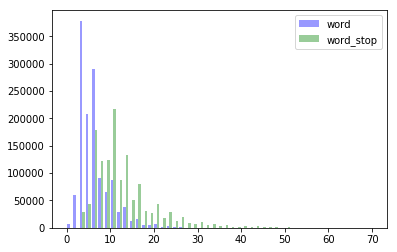

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('seaborn-deep')
bins = np.linspace(0, 70, 50)
colors = ['b','g']

plt.hist([train_data['word_count'], train_data['word_count_stopword']], bins, color=colors, alpha=0.4, label=['word','word_stop'])
plt.legend(loc='upper right')
plt.show()


/Users/yang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


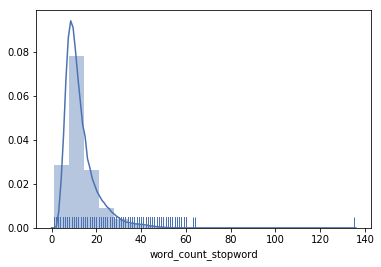

In [48]:
sns.distplot(train_data['word_count_stopword'], bins=20, kde=True, rug=True)


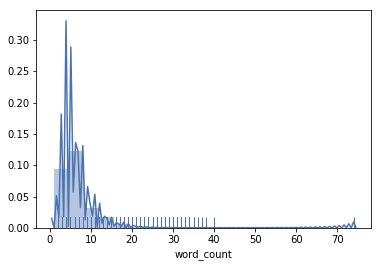

In [49]:
sns.distplot(train_data['word_count'], bins=20, kde=True, rug=True)


In [50]:
p = train_data.loc[(train_data['target'] == 0),]
n = train_data.loc[(train_data['target'] == 1),]


In [51]:
print(n.shape, p.shape)

(80799, 11) (1225221, 11)


## STEP 3 : SPLIT DATA FOR TRAINING, TESTING, AND HOLDING

Create the verification, test, small and mid size data set 


In [1]:
%%time

from joblib import dump, load

train_target =load('data/target.sav')
#train_text = load('data/question_text_lemma.sav')
train_text = load('data/question_text_lemma_stopword.sav')

CPU times: user 862 ms, sys: 323 ms, total: 1.18 s
Wall time: 1.32 s


In [4]:
%%time

from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold  = train_test_split(train_text, train_target, 
                                                     train_size = 0.8, test_size = 0.2, 
                                                     random_state = 42, stratify = train_target)
X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, 
                                                     train_size = 0.9, test_size = 0.1,  
                                                     random_state = 42, stratify = y_train)
X_train, X_small, y_train, y_small  = train_test_split(X_train, y_train, 
                                                       train_size = 0.9, test_size = 0.1,  
                                                       random_state = 42, stratify = y_train)
X_large, X_mid, y_large, y_mid  = train_test_split(X_train, y_train, 
                                                   train_size = 0.7, test_size = 0.3,  
                                                   random_state = 42, stratify = y_train)

print(len(X_hold),len(X_test), len(X_small), len(X_mid), len(X_large), len(train_text))

261204 104482 94034 253890 592410 1306020
CPU times: user 2.23 s, sys: 111 ms, total: 2.34 s
Wall time: 2.34 s


In [5]:
%%time

from sklearn.feature_extraction.text import CountVectorizer

# min_df : float in range [0.0, 1.0] or int, default=1
# max_features : int or None, default=None 
vectorizer = CountVectorizer(max_features=10000)
X_mid = vectorizer.fit_transform(X_mid)
X_small = vectorizer.transform(X_small)
X_test = vectorizer.transform(X_test)
X_hold = vectorizer.transform(X_hold)
print(vectorizer)

#X_mid = X_mid.todense()
#X_small = X_small.todense()
#X_test = X_test.todense()
#X_hold = X_hold.todense()
#print(X_hold.shape, X_small.shape, X_mid.shape, X_large.shape, train_text_lemma_stopword.shape)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
CPU times: user 8.29 s, sys: 164 ms, total: 8.45 s
Wall time: 8.47 s


In [6]:
X_mid

<253890x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 2740909 stored elements in Compressed Sparse Row format>

In [7]:
%%time

from joblib import dump, load

dump(vectorizer, 'data/nn_vectorizer.sav')
dump(X_mid, 'data/nn_X_mid.sav')
dump(y_mid, 'data/nn_y_mid.sav')
dump(X_small, 'data/nn_X_small.sav')
dump(y_small, 'data/nn_y_small.sav')
dump(X_test, 'data/nn_X_test.sav')
dump(y_test, 'data/nn_y_test.sav')
dump(X_hold, 'data/nn_X_hold.sav')
dump(y_hold, 'data/nn_y_hold.sav')


CPU times: user 586 ms, sys: 170 ms, total: 756 ms
Wall time: 968 ms


## STEP 4 : BUILD DNN AND LOGISTICREGRESSION MODEL

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def split(X, y, vectorizer = CountVectorizer(), test_size = 0.2, hold_size = 0.2):
    #split data to train, test & hold, hold will be completed outside the training vector, 
    X_train, X_hold, y_train, y_hold  = train_test_split(X, y, test_size = hold_size, train_size = 1 - hold_size, random_state = 42, stratify = y)
    X_train = vectorizer.fit_transform(X_train)
    X_hold = vectorizer.transform(X_hold)
    X_train, X_test, y_train, y_test  = train_test_split(X_train, y_train, test_size = test_size, train_size = 1 - test_size, random_state = 42, stratify = y_train)
    return  X_train, X_test, X_hold, y_train, y_test, y_hold, vectorizer

def fit(X, y, param_grid, estimator):
    search = GridSearchCV(estimator, param_grid, cv = 5,verbose = 1, scoring = 'roc_auc')
    search.fit(X, y)
    best = search.best_estimator_ 
    best.fit(X, y)
    return best


def report(best, X, y, comp, name):
    target_names = ['Sincere', 'Insincere']
    
    print(best)
    predicted = best.predict(X)
    
    #classification_report 
    report = classification_report(y, predicted, target_names = target_names)
    print(report)
    comp[name] = report

    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt = 'd')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()
    
    #roc curve
    probs = best.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:,0], pos_label = 0)
    roc_auc = auc(fpr, tpr)
    fpr1, tpr1, thresholds1 = roc_curve(y, probs[:,1], pos_label = 1)
    roc_auc1 = auc(fpr1, tpr1)
    
    plt.figure()
    plt.plot(fpr, tpr, color ='blue', lw = 1, label = 'ROC curve for sincere (area = %0.2f)' % roc_auc)
    plt.plot(fpr1, tpr1, color ='red', lw = 1, label = 'ROC curve for insincere (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color ='black', lw = 1, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic' + name)
    plt.legend(loc = "lower right")
    plt.show()

def reportP(best, X, y, comp, name):
    target_names = ['Sincere', 'Insincere']
    
    print(best)
    predicted = best.predict(X)
    
    #classification_report 
    report = classification_report(y, predicted, target_names = target_names)
    print(report)
    comp[name] = report

    #confusion matrix
    matrix = confusion_matrix(y, predicted)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(matrix, annot = True, fmt = 'd')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()
    

In [10]:
%%time

from joblib import dump, load

X_small =load('data/nn_X_small.sav')
y_small =load('data/nn_y_small.sav')

X_mid =load('data/nn_X_mid.sav')
y_mid =load('data/nn_y_mid.sav')


CPU times: user 14.4 ms, sys: 19.6 ms, total: 34 ms
Wall time: 32.6 ms


In [11]:
matrix_compare = {}

In [21]:
%%time

from sklearn.linear_model import LogisticRegression
import numpy as np

param_grid = {'C': [0.1, 0.5, 1, 5, 10], 
              'solver':['lbfgs', 'sag', 'saga'],
              'fit_intercept' :[True, False],
             }        

estimator = LogisticRegression(class_weight='balanced', max_iter = 1000, random_state = 42, verbose = 0)
search_lr = GridSearchCV(estimator, param_grid, cv = 5, verbose = 0, scoring = 'roc_auc')
search_lr.fit(X_small, y_small)
best_lr = search_lr.best_estimator_ 


/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

CPU times: user 33min 14s, sys: 11.5 s, total: 33min 26s
Wall time: 25min 46s


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.99      0.91      0.95    238183
   Insincere       0.39      0.90      0.54     15707

    accuracy                           0.91    253890
   macro avg       0.69      0.91      0.74    253890
weighted avg       0.96      0.91      0.92    253890



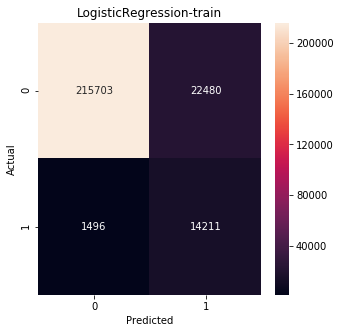

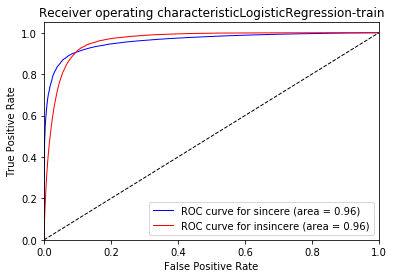

CPU times: user 6.91 s, sys: 140 ms, total: 7.05 s
Wall time: 6.44 s


In [22]:
%%time

best_lr.fit(X_mid, y_mid)
dump(best_lr, 'data/best_nn_lr_model.sav')
report(best_lr, X_mid, y_mid, matrix_compare, 'LogisticRegression-train')

In [ ]:
print(search_lr.score(X_small, y_small))
print(search_lr.best_params_)


In [23]:
from sklearn.linear_model import Perceptron

import numpy as np

param_grid = {'fit_intercept' :[True,],
              'penalty' :['l2','l1','elasticnet'],
              'alpha' :[0.0001, 0.001, 0.01],
             }        

estimator = Perceptron(warm_start=True, class_weight='balanced', early_stopping=True, max_iter = 1000, random_state = 42, verbose = 1)
search_p = GridSearchCV(estimator, param_grid, cv = 5, verbose = 0, scoring = 'roc_auc')
search_p.fit(X_small, y_small)
best_p = search_p.best_estimator_ 


-- Epoch 1
Norm: 211.41, NNZs: 8775, Bias: -7.157780, T: 67703, Avg. loss: 5.361806
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 210.11, NNZs: 9372, Bias: -9.572782, T: 135406, Avg. loss: 5.051240
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 213.56, NNZs: 9583, Bias: -12.983665, T: 203109, Avg. loss: 5.171367
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 201.90, NNZs: 9666, Bias: -11.683064, T: 270812, Avg. loss: 4.902689
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 199.56, NNZs: 9708, Bias: -11.350634, T: 338515, Avg. loss: 4.781785
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 221.91, NNZs: 9735, Bias: -11.603885, T: 406218, Avg. loss: 4.939501
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 201.70, NNZs: 9764, Bias: -11.117672, T: 473921, Avg. loss: 4.697827
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 195.94, NNZs: 9791, Bias: -11.015294, T: 541624, Avg. loss: 4.900949
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 211.19, NNZs: 9802

-- Epoch 1
Norm: 708.80, NNZs: 1853, Bias: -8.771840, T: 67705, Avg. loss: 4.778364
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 1018.22, NNZs: 1225, Bias: -10.761681, T: 135410, Avg. loss: 2.982416
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 1262.00, NNZs: 958, Bias: -10.761502, T: 203115, Avg. loss: 2.309725
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 1484.58, NNZs: 848, Bias: -7.749704, T: 270820, Avg. loss: 1.907429
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 1688.82, NNZs: 808, Bias: -7.829189, T: 338525, Avg. loss: 1.900365
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 1870.21, NNZs: 767, Bias: -7.030497, T: 406230, Avg. loss: 1.855872
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 211.41, NNZs: 8775, Bias: -7.157780, T: 67703, Avg. loss: 5.361806
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 210.11, NNZs: 9372, Bias: -9.572782, T: 135406, Avg. loss: 5.051240
Total training time: 0.04 sec

-- Epoch 1
Norm: 84.94, NNZs: 9117, Bias: -5.959483, T: 67705, Avg. loss: 5.209848
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 102.35, NNZs: 9569, Bias: -6.076274, T: 135410, Avg. loss: 5.026861
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 90.34, NNZs: 9702, Bias: -6.055055, T: 203115, Avg. loss: 4.919909
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 100.19, NNZs: 9771, Bias: -6.587379, T: 270820, Avg. loss: 5.051226
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 93.73, NNZs: 9807, Bias: -6.430538, T: 338525, Avg. loss: 4.768838
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 84.15, NNZs: 9829, Bias: -6.023578, T: 406230, Avg. loss: 4.850209
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 96.17, NNZs: 9847, Bias: -5.956960, T: 473935, Avg. loss: 4.747267
Total training time: 0.12 seconds.
-- Epoch 8
Norm: 87.97, NNZs: 9856, Bias: -6.161024, T: 541640, Avg. loss: 4.879020
Total training time: 0.13 seconds.
-- Epoch 9
Norm: 92.53, NNZs: 9864, Bias: -5.92

-- Epoch 1
Norm: 84.94, NNZs: 9117, Bias: -5.959483, T: 67705, Avg. loss: 5.209848
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 102.35, NNZs: 9569, Bias: -6.076274, T: 135410, Avg. loss: 5.026861
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 90.34, NNZs: 9702, Bias: -6.055055, T: 203115, Avg. loss: 4.919909
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 100.19, NNZs: 9771, Bias: -6.587379, T: 270820, Avg. loss: 5.051226
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 93.73, NNZs: 9807, Bias: -6.430538, T: 338525, Avg. loss: 4.768838
Total training time: 0.12 seconds.
-- Epoch 6
Norm: 84.15, NNZs: 9829, Bias: -6.023578, T: 406230, Avg. loss: 4.850209
Total training time: 0.15 seconds.
-- Epoch 7
Norm: 96.17, NNZs: 9847, Bias: -5.956960, T: 473935, Avg. loss: 4.747267
Total training time: 0.18 seconds.
-- Epoch 8
Norm: 87.97, NNZs: 9856, Bias: -6.161024, T: 541640, Avg. loss: 4.879020
Total training time: 0.20 seconds.
-- Epoch 9
Norm: 92.53, NNZs: 9864, Bias: -5.92

-- Epoch 1
Norm: 1344.62, NNZs: 7, Bias: -0.278891, T: 67704, Avg. loss: 1.878394
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1901.35, NNZs: 3, Bias: -0.008733, T: 135408, Avg. loss: 1.913218
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 2333.12, NNZs: 3, Bias: -0.040796, T: 203112, Avg. loss: 1.875741
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 2698.33, NNZs: 5, Bias: -0.006281, T: 270816, Avg. loss: 1.620087
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 3018.05, NNZs: 5, Bias: -0.055033, T: 338520, Avg. loss: 1.648727
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 3304.38, NNZs: 3, Bias: 0.045534, T: 406224, Avg. loss: 1.743879
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 1351.16, NNZs: 6, Bias: -0.124814, T: 67705, Avg. loss: 2.043005
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1921.59, NNZs: 5, Bias: -0.116764, T: 135410, Avg. loss: 1.552649
Total training time: 0.04 seconds.
-- Epoch 3
Nor

-- Epoch 1
Norm: 1404.02, NNZs: 694, Bias: -8.127684, T: 228501, Avg. loss: 3.224080
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 2117.63, NNZs: 471, Bias: -5.790897, T: 457002, Avg. loss: 1.802326
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 2671.13, NNZs: 423, Bias: -5.630081, T: 685503, Avg. loss: 1.710225
Total training time: 0.24 seconds.
-- Epoch 4
Norm: 3136.49, NNZs: 412, Bias: -4.325286, T: 914004, Avg. loss: 1.600522
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 3538.86, NNZs: 367, Bias: -4.017780, T: 1142505, Avg. loss: 1.653614
Total training time: 0.39 seconds.
-- Epoch 6
Norm: 3898.50, NNZs: 379, Bias: -4.274270, T: 1371006, Avg. loss: 1.616624
Total training time: 0.47 seconds.
Convergence after 6 epochs took 0.50 seconds
Perceptron(alpha=0.0001, class_weight='balanced', early_stopping=True, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l1', random_state=42, shuffle=True, tol=0.001,
      

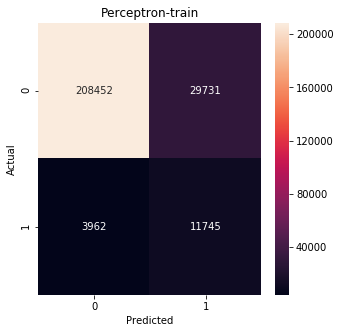

CPU times: user 2.36 s, sys: 110 ms, total: 2.47 s
Wall time: 1.32 s


In [26]:
%%time

best_p.fit(X_mid, y_mid)
dump(best_p, 'data/best_nn_p_model.sav')
reportP(best_p, X_mid, y_mid, matrix_compare, 'Perceptron-train')

In [30]:
%%time

from sklearn.neural_network import MLPClassifier

param_grid = {'hidden_layer_sizes':[(256,128),(512,256,128),(1024,512,256,128)],
              'activation':['relu'],
              'solver': ['adam'], 
              'alpha': [0.0001], 
              'batch_size' :[200],
              'learning_rate':['constant'], 
              'learning_rate_init' :[0.001],
              'max_iter': [1000], 
              'shuffle' :[True],
              'random_state':[42],
              'early_stopping':[True],
              'beta_1' :[0.9],
              'beta_2' :[0.999],
              'epsilon' :[1e-8],
              'n_iter_no_change' :[10],
             }

estimator = MLPClassifier()
search_mlp = GridSearchCV(estimator, param_grid, cv = 5, verbose = 0, scoring = 'roc_auc')
search_mlp.fit(X_small, y_small)
best_mlp = search_mlp.best_estimator_ 


CPU times: user 8h 11min 6s, sys: 1h 8min 1s, total: 9h 19min 7s
Wall time: 3h 31min 54s


In [ ]:
%%time

best_mlp.fit(X_mid, y_mid)
dump(best_mlp, 'data/best_nn_mlp_model.sav')
report(best_mlp, X_mid, y_mid, matrix_compare, 'MLPClassifier-train')

In [ ]:
validation_matrix ={}
X_hold =load('data/nn_X_hold.sav')
y_hold =load('data/nn_y_small.sav')

best_lr
best_p
report(best_lr, X_hold, y_hold, validation_matrix, 'MLPClassifier-hold')
reportP(best_p, X_hold, y_hold, validation_matrix, 'MLPClassifier-hold')
report(best_mlp, X_hold, y_hold, validation_matrix, 'MLPClassifier-hold')



<B>Reference</B>

[MLPClassifier with GridSearchCV](https://www.kaggle.com/hatone/mlpclassifier-with-gridsearchcv)

[sklearn.linear_model.Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)

[sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)


<B>information for next step</B>

<B>[A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)</B>

<B>[An implementation guide to Word2Vec using NumPy and Google Sheets](https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281)</B>

<B>[Approaching (Almost) Any NLP Problem on Kaggle](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle)</B>